## Embeddings

In [43]:
import re, gensim, logging, multiprocessing, datasets, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam

In [2]:
# congig
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
workers = multiprocessing.cpu_count()-1

__paths to change__

In [3]:
output_path = './salida'

__process methods__

In [4]:
def expand_contractions(document: str) -> str:
    """
    Replace all abbreviations with their corresponding expansion
    """
    document = re.sub(r"'cause", "because", document)
    document = re.sub(r"o'clock", "of the clock", document)
    document = re.sub(r"won\'t", "will not", document)
    document = re.sub(r"can\'t", "can not", document)
    document = re.sub(r"n\'t", " not", document)
    document = re.sub(r"\'re", " are", document)
    document = re.sub(r"\'s", " is", document)
    document = re.sub(r"\'d", " would", document)
    document = re.sub(r"\'ll", " will", document)
    document = re.sub(r"\'t", " not", document)
    document = re.sub(r"\'ve", " have", document)
    document = re.sub(r"\'m", " am", document)
    return document

In [5]:
def replace_numbers(document: str) -> str:
    """
    Replace number appearances with 'number'
    """
    # Case 1: Combination of numbers and letters (Eg. 2nd -> NUM)
    document = re.sub('[a-zA-Z]+[0-9]+[a-zA-Z]+', 'number', document)
    document = re.sub('[0-9]+[a-zA-Z]+|[a-zA-Z]+[0-9]+', 'number', document)
    # Case 2: Decimal numbers (Eg. 2.1 -> NUM)
    document = re.sub('[0-9]+\.+[0-9]+', 'number', document)
    # Case 3: Numbers between spaces (Eg. 220 888 -> NUM)
    document = re.sub('([0-9]+\s)*[0-9]+', 'number', document)
    # Case 4: One or more of the previous cases (Eg. NUM NUM -> NUM)
    document = re.sub('((NUM)+\s)*(NUM)+', 'number', document)
    return document

In [6]:
def preprocessing(document: str) -> list:
    """
    iterate over all words in document identifing the word and frecuency
    remove all the problematic characters over the word
    and return a dictionary with the word as the key and the frecuency as the value
    """
    document = document.lower()
    document = expand_contractions(document)
    document = replace_numbers(document)
    document = re.sub('[^A-Za-z]+', ' ', document)
    document = document.split()
    return document

In [7]:
def get_sentences() -> pd.DataFrame:
    """
    read and process document
    """
    dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
    df = dataset['train'].to_pandas()
    data = pd.DataFrame()
    data['text'] = df.text
    data['processed'] = df.text.apply(preprocessing)
    data['hatespeech'] = df.hatespeech.apply(lambda x: math.ceil(x/2))
    return data

In [8]:
def train_model(size: int, window: int, data: list, epochs: int) -> gensim.models.Word2Vec:
    """
    Train the word2vec embedding
    """
    model = gensim.models.Word2Vec(sentences=data, 
                                   vector_size=size, 
                                   window=window, 
                                   workers=workers, 
                                   min_count=3, 
                                   alpha=0.025, 
                                   min_alpha=0.0007)
    model.build_vocab(data, progress_per=100000)
    model.train(data, total_examples=len(data), epochs=epochs)
    return model

__train models__

In [9]:
sentences = get_sentences()
sentences.sample(10)

2022-07-26 22:45:45,823 : WARNING : Using custom data configuration ucberkeley-dlab--measuring-hate-speech-1d47093687320b66
2022-07-26 22:45:45,854 : WARNING : Reusing dataset parquet (C:\Users\Usuario\.cache\huggingface\datasets\ucberkeley-dlab___parquet\ucberkeley-dlab--measuring-hate-speech-1d47093687320b66\0.0.0\7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/1 [00:00<?, ?it/s]

,text,processed,hatespeech
49004,THis is why we need Islam,"[this, is, why, we, need, islam]",0
92600,@Legionary1488 @JomavaesJos now we have a Eblo...,"[number, jomavaesjos, now, we, have, a, ebloa,...",1
19126,To paraphrase thoughts from the last time Kent...,"[to, paraphrase, thoughts, from, the, last, ti...",1
115614,Black people cant take jokes #bigfacts Here co...,"[black, people, cant, take, jokes, bigfacts, h...",1
22260,fuk faze bunch of bitches,"[fuk, faze, bunch, of, bitches]",1
71680,"""Brunette Beauty Gabriella Paltrova Fucks Him ...","[brunette, beauty, gabriella, paltrova, fucks,...",1
58955,That shit played off. Fucking fags,"[that, shit, played, off, fucking, fags]",1
56087,"Yeah and Kamala ""headboard "" Harris is descen...","[yeah, and, kamala, headboard, harris, is, des...",0
49759,Considering there is a large LGBT community wi...,"[considering, there, is, a, large, lgbt, commu...",0
76060,"From 'lock her up!, lock her up!', to 'send he...","[from, lock, her, up, lock, her, up, to, isend...",0


In [10]:
#Train embedding
embedding = train_model(size=60, window=3, data=list(sentences['processed']), epochs=50)

2022-07-26 22:45:53,276 : INFO : collecting all words and their counts
2022-07-26 22:45:53,277 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-07-26 22:45:53,305 : INFO : PROGRESS: at sentence #10000, processed 260239 words, keeping 19201 word types
2022-07-26 22:45:53,374 : INFO : PROGRESS: at sentence #20000, processed 519498 words, keeping 28373 word types
2022-07-26 22:45:53,413 : INFO : PROGRESS: at sentence #30000, processed 784049 words, keeping 32838 word types
2022-07-26 22:45:53,443 : INFO : PROGRESS: at sentence #40000, processed 1042524 words, keeping 35810 word types
2022-07-26 22:45:53,474 : INFO : PROGRESS: at sentence #50000, processed 1307330 words, keeping 38072 word types
2022-07-26 22:45:53,508 : INFO : PROGRESS: at sentence #60000, processed 1565718 words, keeping 39324 word types
2022-07-26 22:45:53,534 : INFO : PROGRESS: at sentence #70000, processed 1824124 words, keeping 40644 word types
2022-07-26 22:45:53,566 : INFO : PROGRESS:

In [11]:
#Save model
embedding.save(f'{output_path}/embedding.model')

2022-07-26 22:47:11,968 : INFO : Word2Vec lifecycle event {'fname_or_handle': './salida/embedding.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-07-26T22:47:11.968665', 'gensim': '4.2.0', 'python': '3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'saving'}
2022-07-26 22:47:11,970 : INFO : not storing attribute cum_table
2022-07-26 22:47:12,008 : INFO : saved ./salida/embedding.model


In [12]:
#Load models
embedding = gensim.models.Word2Vec.load(f'{output_path}/embedding.model')

2022-07-26 22:47:12,029 : INFO : loading Word2Vec object from ./salida/embedding.model
2022-07-26 22:47:12,061 : INFO : loading wv recursively from ./salida/embedding.model.wv.* with mmap=None
2022-07-26 22:47:12,062 : INFO : setting ignored attribute cum_table to None
2022-07-26 22:47:12,339 : INFO : Word2Vec lifecycle event {'fname': './salida/embedding.model', 'datetime': '2022-07-26T22:47:12.339562', 'gensim': '4.2.0', 'python': '3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'loaded'}


In [13]:
embedding.wv.most_similar(positive=["california", "texas", "florida"], topn=25)

[('city', 0.6000299453735352),
 ('cuntry', 0.5800144672393799),
 ('punjab', 0.5570152997970581),
 ('canada', 0.5454503893852234),
 ('louisiana', 0.5220199823379517),
 ('minnesota', 0.5208011865615845),
 ('mexico', 0.5126967430114746),
 ('charlottesville', 0.5081894993782043),
 ('cuba', 0.5042896866798401),
 ('twenty', 0.5003750920295715),
 ('europe', 0.4981015920639038),
 ('mombasa', 0.4918789863586426),
 ('dayton', 0.48139140009880066),
 ('cleaners', 0.4790172576904297),
 ('england', 0.47719606757164),
 ('egypt', 0.47691085934638977),
 ('sanctuary', 0.47684207558631897),
 ('virginia', 0.47573208808898926),
 ('exile', 0.4734196066856384),
 ('kansas', 0.4729955494403839),
 ('droves', 0.4718984365463257),
 ('berlin', 0.4714069664478302),
 ('gamestop', 0.47027239203453064),
 ('iraq', 0.46955493092536926),
 ('france', 0.4670475423336029)]

## train the ML model

In [14]:
def sentence_to_embedding(sentence: str) -> np.array:
    """
    Returns the element-wise mean of the embeddings that represent each word in a sentence
    """
    words = preprocessing(sentence)
    vector = np.zeros(embedding.layer1_size)
    counter = 0
    for word in words:
        try:
            vector += embedding.wv[word]
            counter += 1
        except:
            pass
    if counter > 0:
        vector = vector / counter
    return vector

In [15]:
y_sample = sentences['hatespeech'].astype(float)
X_sample = sentences['text'].astype(str)

X_train_validation, X_test, y_train_validation, y_test = train_test_split(X_sample.values, 
                                                    y_sample.values, 
                                                    random_state=42,test_size=0.2)

X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, 
                                                    y_train_validation, 
                                                    random_state=42,test_size=0.125)

print('Number of rows in the total set: {}'.format(X_sample.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the validation set: {}'.format(X_validation.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 135556
Number of rows in the training set: 94888
Number of rows in the validation set: 13556
Number of rows in the test set: 27112


In [16]:
X_train = pd.DataFrame(X_train, columns=['data']).data.apply(sentence_to_embedding)
X_validation = pd.DataFrame(X_validation, columns=['data']).data.apply(sentence_to_embedding)
X_test = pd.DataFrame(X_test, columns=['data']).data.apply(sentence_to_embedding)

In [17]:
# Create the classification model
model = Sequential()
model.add(Dense(150,  activation='relu'))
model.add(Dense(110, activation='relu'))
model.add(Dense(75, activation='relu'))
model.add(Dense(45, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='relu'))
model.add(Activation('sigmoid'))

In [42]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [19]:
# Train the model
history = model.fit(x=np.asarray(X_train.to_list()).astype('float32'),
                    y=y_train,
                    batch_size=32, 
                    epochs=20,
                    validation_data=(np.asarray(X_validation.to_list()).astype('float32'), y_validation),
                    shuffle=True)

Epoch 1/20
2966/2966 [==============================] - 5s 2ms/step - loss: 0.6238 - accuracy: 0.7575 - val_loss: 0.6185 - val_accuracy: 0.7651
Epoch 2/20
2966/2966 [==============================] - 4s 1ms/step - loss: 0.6155 - accuracy: 0.7707 - val_loss: 0.6181 - val_accuracy: 0.7608
Epoch 3/20
2966/2966 [==============================] - 4s 1ms/step - loss: 0.6126 - accuracy: 0.7753 - val_loss: 0.6249 - val_accuracy: 0.7475
Epoch 4/20
2966/2966 [==============================] - 4s 1ms/step - loss: 0.6118 - accuracy: 0.7733 - val_loss: 0.6145 - val_accuracy: 0.7704
Epoch 5/20
2966/2966 [==============================] - 4s 1ms/step - loss: 0.6111 - accuracy: 0.7748 - val_loss: 0.6164 - val_accuracy: 0.7699
Epoch 6/20
2966/2966 [==============================] - 4s 1ms/step - loss: 0.6085 - accuracy: 0.7817 - val_loss: 0.6122 - val_accuracy: 0.7748
Epoch 7/20
2966/2966 [==============================] - 4s 1ms/step - loss: 0.6066 - accuracy: 0.7852 - val_loss: 0.6149 - val_accuracy:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               9150      
                                                                 
 dense_1 (Dense)             (None, 110)               16610     
                                                                 
 dense_2 (Dense)             (None, 75)                8325      
                                                                 
 dense_3 (Dense)             (None, 45)                3420      
                                                                 
 dense_4 (Dense)             (None, 15)                690       
                                                                 
 dense_5 (Dense)             (None, 1)                 16        
                                                                 
 activation (Activation)     (None, 1)                 0

In [21]:
accr = model.evaluate(np.asarray(X_test.to_list()).astype('float32'), y_test)
accr

848/848 [==============================] - 1s 712us/step - loss: 0.6162 - accuracy: 0.7799


[0.6161705851554871, 0.7798760533332825]

In [32]:
pred = model.predict(np.asarray(X_test.to_list()).astype('float32'), verbose=1)

848/848 [==============================] - 0s 521us/step


In [41]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.616
  Accuracy: 0.780


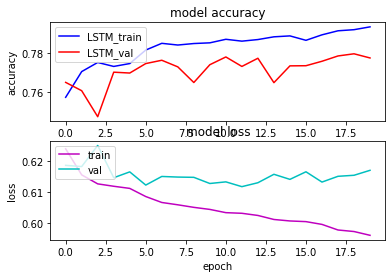

In [25]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')